In [269]:
from ase import io
import subprocess

reaction_idx = 24
paths = [f'./generation/oapainn/iteration{i}/{reaction_idx}/reaction_p_align.xyz' for i in range(64)]
smis = []

for i in range(64):
    str1 = f'./generation/oapainn/iteration{i}/{reaction_idx}/reaction_p_align.xyz'

    smi = subprocess.run(
        'obabel ' +  f'./generation/oapainn/iteration{i}/{reaction_idx}/reaction_p_align.xyz -osmi',
        capture_output=True,
        text=True,
        shell=True,
    ).stdout
    
    smis.append(smi.split('\t')[0])
    
molecules = [io.read(path) for path in paths]

In [270]:
import numpy as np

assert len(molecules) == len(smis)
print(f'all smiles counts {len(smis)}')
print(f'unique smiles counts {len(np.unique(np.array(smis)))}')

all smiles counts 64
unique smiles counts 8


In [271]:
from concurrent.futures import ThreadPoolExecutor

def calculate_rmsd(i, j):
    rmsd = subprocess.run(
        f'calculate_rmsd ./generation/oapainn/iteration{i}/{reaction_idx}/reaction_p_align.xyz \
        ./generation/oapainn/iteration{j}/{reaction_idx}/reaction_p_align.xyz -e',
        capture_output=True,
        text=True,
        shell=True,
    ).stdout
    return float(rmsd)

def fill_distance_matrix(paths):
    distance_matrix = np.zeros((len(paths), len(paths)))
    
    with ThreadPoolExecutor() as executor:
        futures = {}
        for i in range(len(paths)):
            for j in range(len(paths)):
                futures[(i, j)] = executor.submit(calculate_rmsd, i, j)
        
        for (i, j), future in futures.items():
            distance_matrix[i][j] = future.result()

    return distance_matrix

distance_matrix = fill_distance_matrix(paths)


In [272]:
from sklearn.manifold import MDS

distance_matrix = (distance_matrix + distance_matrix.T) / 2
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
low_dim_embeddings = mds.fit_transform(distance_matrix)


/home/xmcao/.local/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [339]:
from sklearn.cluster import KMeans

k = len(np.unique(np.array(smis))) - 2
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(low_dim_embeddings)

/home/xmcao/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


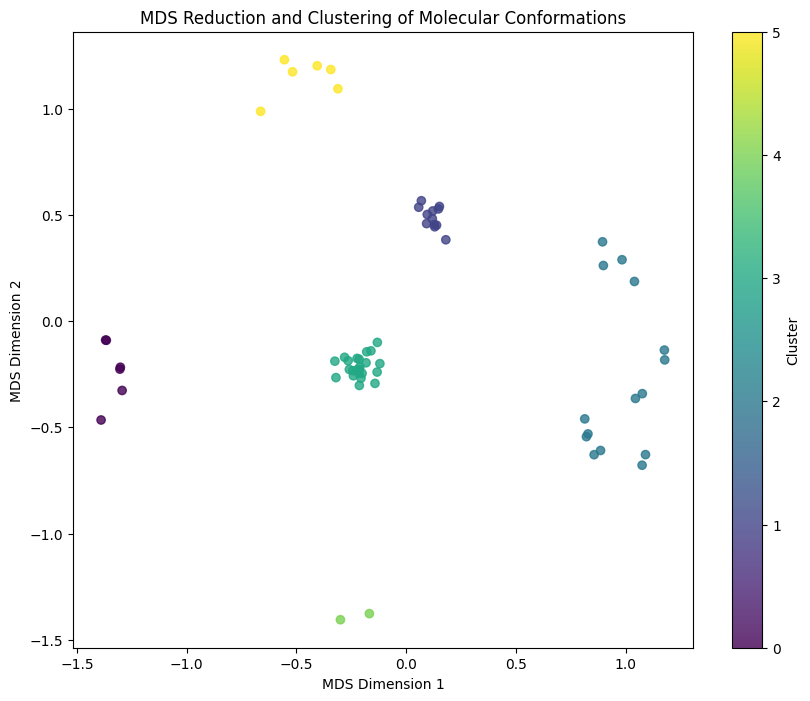

In [360]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
# random deviation
jitter = 0.05
x_jitter = jitter * np.random.randn(low_dim_embeddings.shape[0])
y_jitter = jitter * np.random.randn(low_dim_embeddings.shape[0])

scatter = plt.scatter(low_dim_embeddings[:, 0] + x_jitter, 
                      low_dim_embeddings[:, 1] + y_jitter, 
                      c=clusters, cmap='viridis', alpha=0.8)  
plt.title('MDS Reduction and Clustering of Molecular Conformations')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [392]:
product_list = []
for i in range(k):
    idx = np.where(clusters == i)[0]
    smi = np.array(smis)[idx]
    product_list.append([f'cluster{i}', idx, smi])

In [393]:
product_list

[['cluster0',
  array([15, 17, 20, 28, 41, 50]),
  array(['[N]([C][CH2])[N]#[C]', '[N]([C][CH2])[N]#[C]',
         '[N]([C][CH2])[N]#[C]', '[N]([C][CH2])[N]#[C]', '[N]([C][CH2])C#N',
         '[N]([C][CH2])[N]#[C]'], dtype='<U20')],
 ['cluster1',
  array([ 0,  8, 12, 16, 19, 27, 29, 35, 39, 45, 52, 58]),
  array(['[N](#[C])CC#N', '[N](#[C])CC#N', '[N](#[C])CC#N', '[N](#[C])CC#N',
         '[N](#[C])CC#N', '[N](#[C])CC#N', '[N](#[C])CC#N', '[N](#[C])CC#N',
         '[N](#[C])CC#N', '[N](#[C])CC#N', '[N](#[C])CC#N', '[N](#[C])CC#N'],
        dtype='<U20')],
 ['cluster2',
  array([ 9, 10, 13, 18, 25, 30, 34, 38, 40, 42, 49, 54, 60, 61, 63]),
  array(['N#C[CH][C][NH]', 'N#C[CH][C][NH]', 'N#C[CH][C][NH]',
         'N#C[CH][C][NH]', 'N#C[CH][C][NH]', 'N#C[CH][C][NH]',
         'N#C[CH][C][NH]', 'N#C[CH][C][NH]', 'N#C[CH][C][NH]',
         'N#C[CH][C][NH]', 'N#C[CH][C][NH]', 'N#C[CH][C][NH]',
         'N#C[CH][C][NH]', 'N#C[CH][C][NH]', 'N#C[CH][C][NH]'], dtype='<U20')],
 ['cluster3',
  array